In [1]:
import numpy as np 
import time
import os

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
from utils.inference import Trainer, plot_loss
from utils.models import DNN
import utils.datasets as d
import utils.layers as layers

In [3]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [4]:
print(X.shape, y.shape)

(83680, 160) (83680,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [8]:
train = d.H_alphaSequences(X_train, y_train)
valid = d.H_alphaSequences(X_validation, y_validation)
test = d.H_alphaSequences(X_test, y_test)

# LSTM

In [35]:
class LSTM_cut(nn.Module):
    def __init__(self, **kwargs):
        super(LSTM_cut, self).__init__()
        self.layer = nn.LSTM(**kwargs)
    
    def forward(self,x):
        out, (h,c) = self.layer(x)
        return out.reshape(-1, self.layer.hidden_size*pow(2,int(self.layer.bidirectional))*160)

In [41]:
clf1 = nn.Sequential(
                layers.Reshape(out_shape=(160, 1)), #(batch, seq, feature)
                LSTM_cut(input_size=1, hidden_size=60, num_layers=1, batch_first=True, dropout=0, bidirectional=True),
                #layers.Reshape(out_shape=(19200)),
                nn.Linear(in_features=120*160, out_features=4)
)

In [29]:
#clf1(torch.tensor(X_train[:2,:]).float())

In [42]:
optimizer= torch.optim.Adam(clf1.parameters(), lr=1e-3)

In [43]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=100, shuffle=True)

In [44]:
m1 = Trainer(
        model=clf1,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        #scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1),
        tensorboard=True,
        model_name="LSTM-60x2_lr-1e-3_bs-100",
        verbose=True
        )

cuda:0


In [45]:
lh = m1(epochs=100, train_loader=train_loader, validation_loader=valid_loader)

Epoch [1/100], average_loss:0.6229, validation_loss:0.5487, val_accuracy:0.8539
Epoch [2/100], average_loss:0.5369, validation_loss:0.5414, val_accuracy:0.6966
Epoch [3/100], average_loss:0.5136, validation_loss:0.5131, val_accuracy:0.7528
Epoch [4/100], average_loss:0.5038, validation_loss:0.4930, val_accuracy:0.8539
Epoch [5/100], average_loss:0.4949, validation_loss:0.4857, val_accuracy:0.7528
Epoch [6/100], average_loss:0.4853, validation_loss:0.4857, val_accuracy:0.7978
Epoch [7/100], average_loss:0.4792, validation_loss:0.4944, val_accuracy:0.7191
Epoch [8/100], average_loss:0.4733, validation_loss:0.4611, val_accuracy:0.8539
Epoch [9/100], average_loss:0.4626, validation_loss:0.4542, val_accuracy:0.8090
Epoch [10/100], average_loss:0.4560, validation_loss:0.4504, val_accuracy:0.8315
Epoch [11/100], average_loss:0.4468, validation_loss:0.4541, val_accuracy:0.8090
Epoch [12/100], average_loss:0.4379, validation_loss:0.4305, val_accuracy:0.8427
Epoch [13/100], average_loss:0.4319, 

In [46]:
m1.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m1.model(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)

In [47]:
x_pred

tensor([1, 1, 1,  ..., 3, 1, 0])

In [48]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.8710916766091715

In [49]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.923458413001912

In [50]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[ 3814,   300,    24,    97],
       [  257, 10058,    31,    99],
       [   31,    23,   408,    17],
       [  272,   106,    24,  1175]], dtype=int64)

In [51]:
lh = m1(epochs=range(100,150), train_loader=train_loader, validation_loader=valid_loader)

Epoch [101/150], average_loss:0.1420, validation_loss:0.2426, val_accuracy:0.9101
Epoch [102/150], average_loss:0.1383, validation_loss:0.2468, val_accuracy:0.9101
Epoch [103/150], average_loss:0.1340, validation_loss:0.2411, val_accuracy:0.9326
Epoch [104/150], average_loss:0.1355, validation_loss:0.2373, val_accuracy:0.9663
Epoch [105/150], average_loss:0.1306, validation_loss:0.2457, val_accuracy:0.9326
Epoch [106/150], average_loss:0.1296, validation_loss:0.2415, val_accuracy:0.9213
Epoch [107/150], average_loss:0.1367, validation_loss:0.2614, val_accuracy:0.9213
Epoch [108/150], average_loss:0.1589, validation_loss:0.2308, val_accuracy:0.9551
Epoch [109/150], average_loss:0.1369, validation_loss:0.2264, val_accuracy:0.9551
Epoch [110/150], average_loss:0.1296, validation_loss:0.2324, val_accuracy:0.8876
Epoch [111/150], average_loss:0.1268, validation_loss:0.2323, val_accuracy:0.9326
Epoch [112/150], average_loss:0.1255, validation_loss:0.2351, val_accuracy:0.8876
Epoch [113/150],

In [52]:
m1.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m1.model(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)

In [53]:
x_pred

tensor([1, 1, 1,  ..., 3, 1, 0])

In [54]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.8792134703533798

In [55]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.9279397705544933

In [56]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[ 3676,   289,    27,   243],
       [  199, 10130,    31,    85],
       [   22,    27,   417,    13],
       [  183,    66,    21,  1307]], dtype=int64)

In [57]:
#torch.save(m1.model.state_dict(), "models_and_losses/LSTM-60x2_lr-1e-3_bs-100.pt")

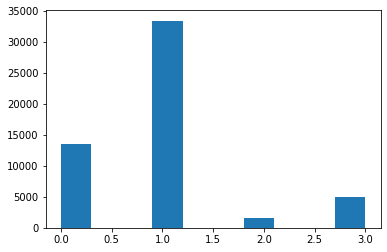

In [9]:
plt.figure()
plt.hist(y_train)
plt.show()

# LSTM m.II

In [14]:
clf2 = nn.Sequential(
                layers.Reshape(out_shape=(160, 1)), #(batch, seq, feature)
                layers.LSTM_mod(sequence_len=160, input_size=1, hidden_size=60, num_layers=1, batch_first=True, dropout=0, bidirectional=True),
                #layers.Reshape(out_shape=(19200)),
                nn.Linear(in_features=120*160, out_features=4)
)

In [15]:
#clf1(torch.tensor(X_train[:2,:]).float())

In [16]:
optimizer= torch.optim.Adam(clf2.parameters(), lr=1e-3)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=512, shuffle=True)

In [18]:
m2 = Trainer(
        model=clf2,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        #scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1),
        tensorboard=True,
        model_name="LSTM-60x1_lr-1e-3_bs-512",
        verbose=True
        )

cuda:0


In [19]:
lh = m2(epochs=100, train_loader=train_loader, validation_loader=valid_loader)

Epoch [1/100], average_loss:0.7175, validation_loss:0.6127, val_accuracy:0.8312
Epoch [2/100], average_loss:0.5720, validation_loss:0.5494, val_accuracy:0.8312
Epoch [3/100], average_loss:0.5375, validation_loss:0.5326, val_accuracy:0.7792
Epoch [4/100], average_loss:0.5271, validation_loss:0.5156, val_accuracy:0.7662
Epoch [5/100], average_loss:0.5203, validation_loss:0.5147, val_accuracy:0.7792
Epoch [6/100], average_loss:0.5129, validation_loss:0.5086, val_accuracy:0.7922
Epoch [7/100], average_loss:0.5060, validation_loss:0.5014, val_accuracy:0.7922
Epoch [8/100], average_loss:0.4949, validation_loss:0.4890, val_accuracy:0.7922
Epoch [9/100], average_loss:0.4874, validation_loss:0.4832, val_accuracy:0.7922
Epoch [10/100], average_loss:0.4823, validation_loss:0.4812, val_accuracy:0.8052
Epoch [11/100], average_loss:0.4719, validation_loss:0.4698, val_accuracy:0.8442
Epoch [12/100], average_loss:0.4666, validation_loss:0.4788, val_accuracy:0.8831
Epoch [13/100], average_loss:0.4644, 

In [24]:
lh = m2(epochs=range(100,300), train_loader=train_loader, validation_loader=valid_loader)

Epoch [101/300], average_loss:0.4247, validation_loss:0.4440, val_accuracy:0.8312
Epoch [102/300], average_loss:0.4085, validation_loss:0.4376, val_accuracy:0.7662
Epoch [103/300], average_loss:0.3973, validation_loss:0.4433, val_accuracy:0.6753
Epoch [104/300], average_loss:0.3904, validation_loss:0.4054, val_accuracy:0.7792
Epoch [105/300], average_loss:0.3606, validation_loss:0.3589, val_accuracy:0.8182
Epoch [106/300], average_loss:0.3209, validation_loss:0.3405, val_accuracy:0.8571
Epoch [107/300], average_loss:0.3155, validation_loss:0.3317, val_accuracy:0.8701
Epoch [108/300], average_loss:0.3095, validation_loss:0.3304, val_accuracy:0.8571
Epoch [109/300], average_loss:0.3018, validation_loss:0.3239, val_accuracy:0.9091
Epoch [110/300], average_loss:0.2946, validation_loss:0.3057, val_accuracy:0.8571
Epoch [111/300], average_loss:0.2886, validation_loss:0.3179, val_accuracy:0.9091
Epoch [112/300], average_loss:0.2827, validation_loss:0.2932, val_accuracy:0.8961
Epoch [113/300],

Epoch [201/300], average_loss:0.1670, validation_loss:0.2367, val_accuracy:0.9091
Epoch [202/300], average_loss:0.1647, validation_loss:0.2439, val_accuracy:0.8961
Epoch [203/300], average_loss:0.1641, validation_loss:0.2455, val_accuracy:0.8701
Epoch [204/300], average_loss:0.1637, validation_loss:0.2514, val_accuracy:0.8831
Epoch [205/300], average_loss:0.1625, validation_loss:0.2323, val_accuracy:0.9481
Epoch [206/300], average_loss:0.1620, validation_loss:0.2459, val_accuracy:0.8442
Epoch [207/300], average_loss:0.1581, validation_loss:0.2402, val_accuracy:0.8701
Epoch [208/300], average_loss:0.1586, validation_loss:0.2349, val_accuracy:0.9610
Epoch [209/300], average_loss:0.1587, validation_loss:0.2317, val_accuracy:0.9481
Epoch [210/300], average_loss:0.1605, validation_loss:0.2488, val_accuracy:0.8701
Epoch [211/300], average_loss:0.1535, validation_loss:0.2554, val_accuracy:0.9091
Epoch [212/300], average_loss:0.1543, validation_loss:0.2344, val_accuracy:0.9610
Epoch [213/300],

In [25]:
m2.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m2.model(torch.tensor(X_test).float().to(m2.device)).cpu().detach(), axis=1)

In [26]:
x_pred

tensor([1, 1, 1,  ..., 3, 1, 0])

In [27]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.8768538564045317

In [28]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.9294933078393881

In [29]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[ 3846,   189,    39,   161],
       [  276, 10040,    30,    99],
       [   18,    17,   425,    19],
       [  217,    79,    36,  1245]], dtype=int64)

In [30]:
#torch.save(m2.model, "models_and_losses/LSTM-60x1_lr-1e-3_bs-512_epoch-300.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM_mod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon 

In [31]:
lh = m2(epochs=range(300,400), train_loader=train_loader, validation_loader=valid_loader)

Epoch [301/400], average_loss:0.1125, validation_loss:0.2173, val_accuracy:0.9221
Epoch [302/400], average_loss:0.1250, validation_loss:0.2268, val_accuracy:0.9351
Epoch [303/400], average_loss:0.1124, validation_loss:0.2214, val_accuracy:0.9221
Epoch [304/400], average_loss:0.1084, validation_loss:0.2286, val_accuracy:0.9610
Epoch [305/400], average_loss:0.1027, validation_loss:0.2129, val_accuracy:0.9481
Epoch [306/400], average_loss:0.1057, validation_loss:0.2243, val_accuracy:0.9610
Epoch [307/400], average_loss:0.1103, validation_loss:0.2280, val_accuracy:0.9221
Epoch [308/400], average_loss:0.1046, validation_loss:0.2350, val_accuracy:0.9091
Epoch [309/400], average_loss:0.0974, validation_loss:0.2129, val_accuracy:0.9740
Epoch [310/400], average_loss:0.1020, validation_loss:0.2103, val_accuracy:0.9351
Epoch [311/400], average_loss:0.0954, validation_loss:0.2091, val_accuracy:0.9221
Epoch [312/400], average_loss:0.0982, validation_loss:0.2102, val_accuracy:0.9870
Epoch [313/400],

In [32]:
m2.model.eval()
with torch.no_grad():
    x_pred = np.argmax(m2.model(torch.tensor(X_test).float().to(m2.device)).cpu().detach(), axis=1)

In [33]:
x_pred

tensor([1, 1, 1,  ..., 3, 1, 0])

In [34]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.8842408859338318

In [35]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.9354684512428298

In [36]:
confusion_matrix(y_true=y_test, y_pred=x_pred)

array([[ 3768,   244,    29,   194],
       [  162, 10204,    19,    60],
       [   24,    18,   407,    30],
       [  198,    81,    21,  1277]], dtype=int64)

In [37]:
#torch.save(m2.model, "models_and_losses/LSTM-60x1_lr-1e-3_bs-512_epoch-400.pt")